In [1]:
# Install catalax
# !pip install catalax

In [2]:
import json
import jax.numpy as jnp
import numpy as np

import catalax as ctx
import catalax.mcmc as cmc

In [3]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

# Save the model
model.save("./models/", "menten_model")

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[K_m, v_max]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


In [4]:
# Load data
data = jnp.load("./data/data.npy")
time = jnp.load("./data/time.npy")
initial_conditions = json.load(open("./data/initial_conditions.json", "r"))

# Corrup the data to receive higher uncertainties
data = np.random.normal(data, 5.0).clip(min=0)

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (120, 6) | Data: (120, 6, 1)


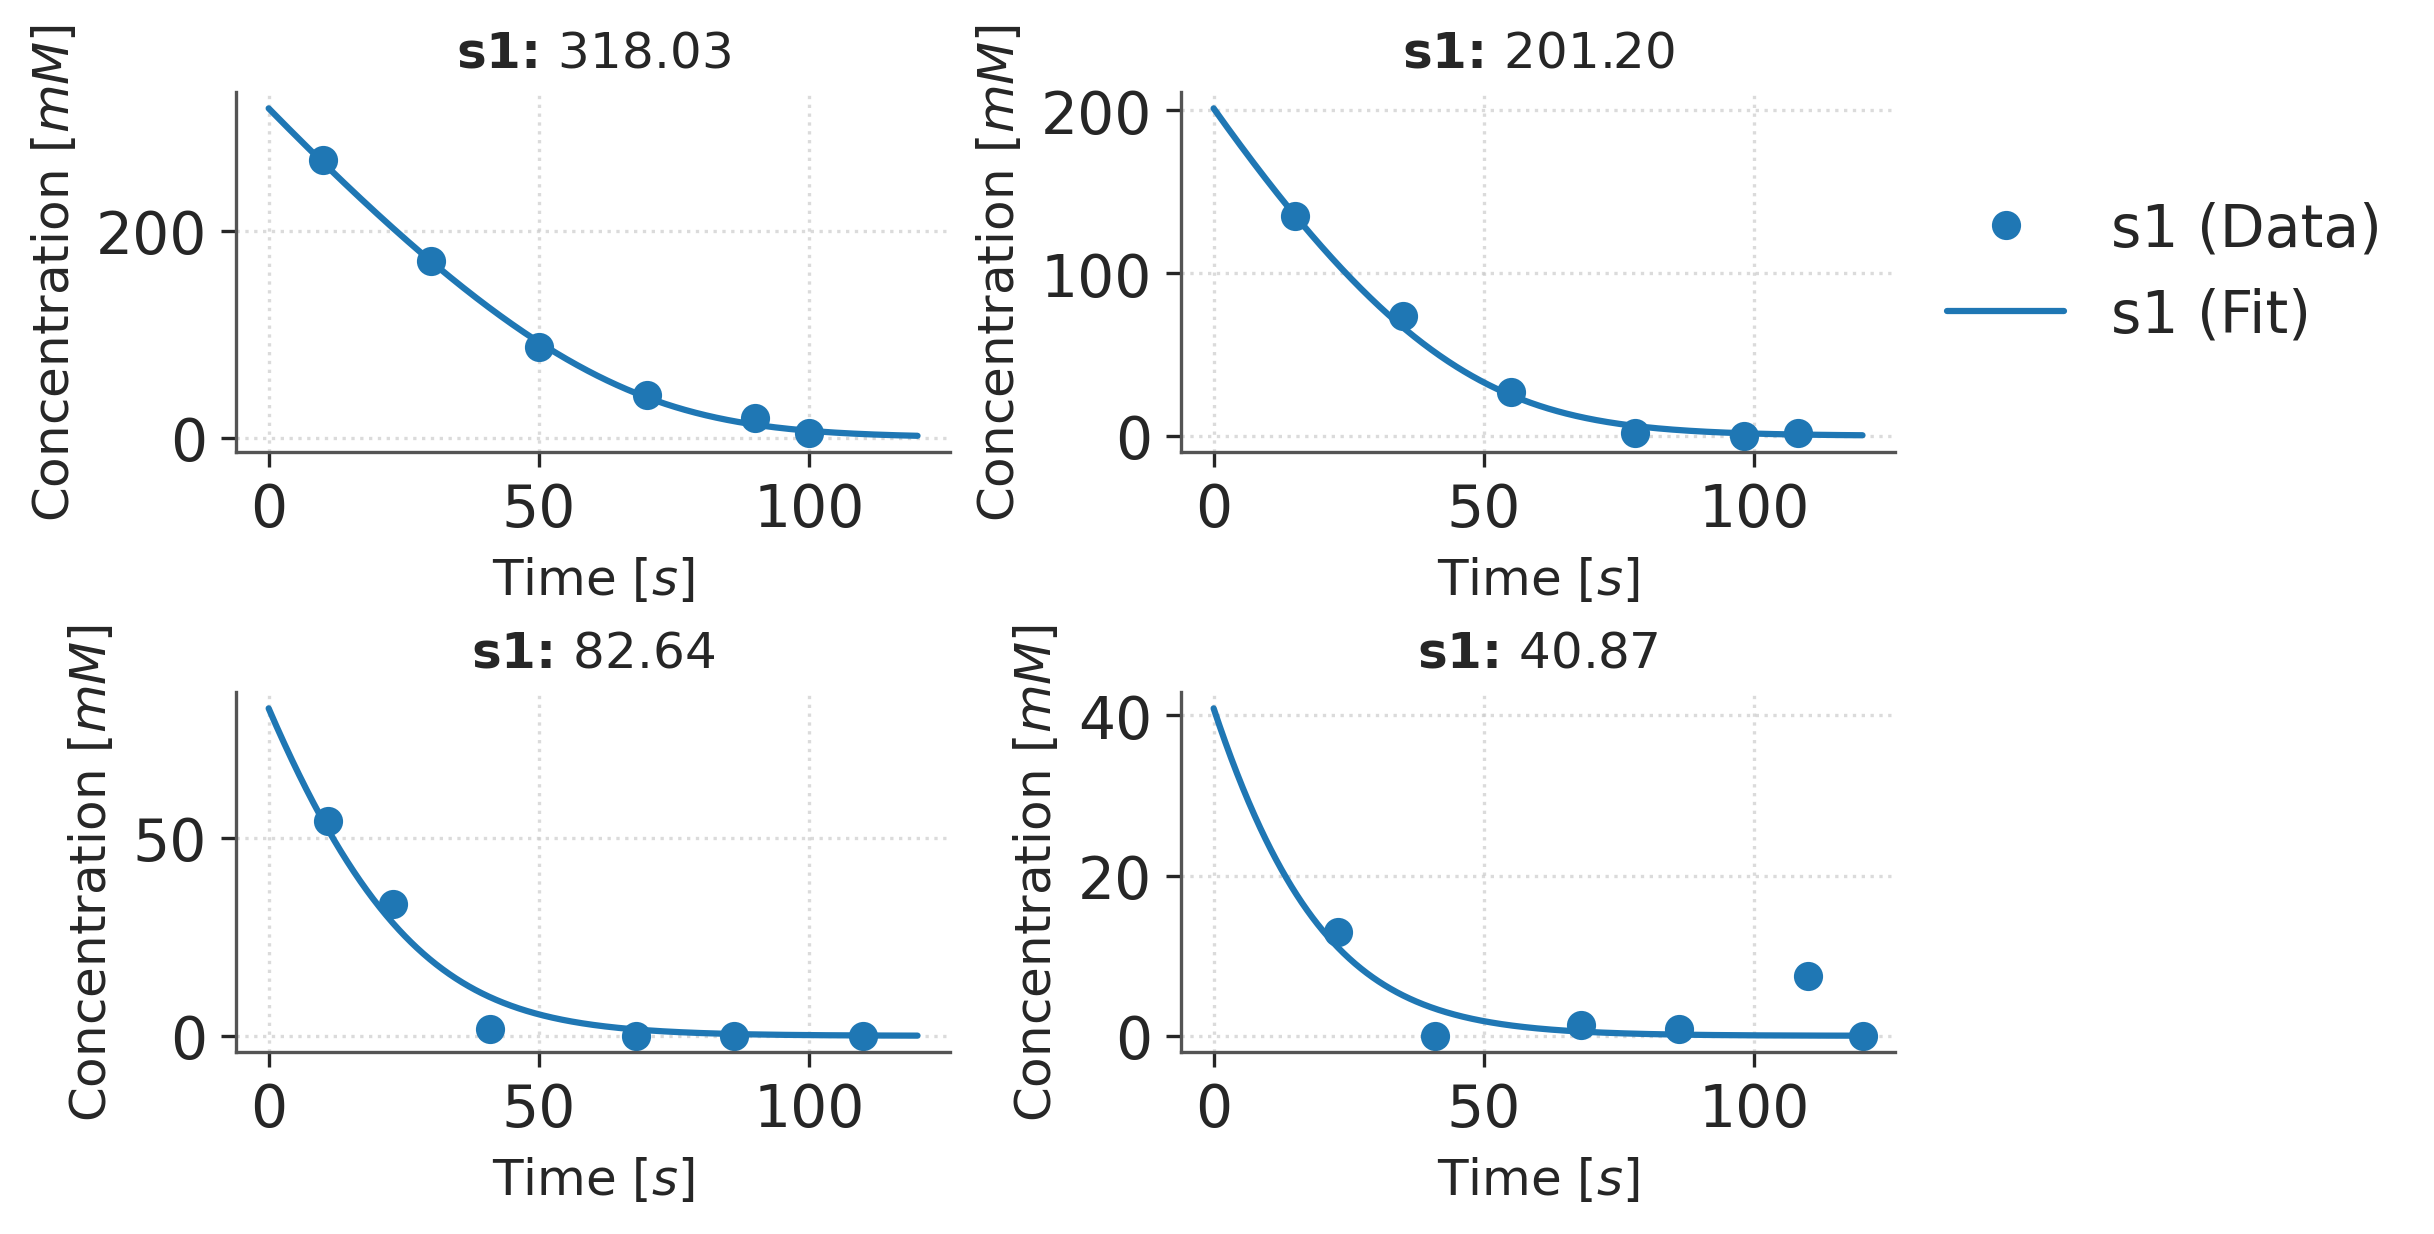

In [5]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)

In [6]:
# Define Priors
model.parameters.v_max.prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters.K_m.prior = cmc.priors.Uniform(low=1e-6, high=1e3)

model.parameters.v_max.prior

# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [7]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64**4
)

🔸 Priors
├── K_m: U(low=1e-06, high=1000.0)
├── v_max: U(low=1e-06, high=200.0)

🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [01:23<00:00, 23.83it/s, 7 steps of size 6.70e-01. acc. prob=0.90] 



🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    102.34      3.20    102.31     96.30    107.05    641.93      1.00
     sigma      4.67      0.12      4.66      4.47      4.86    713.91      1.00
     v_max      7.08      0.09      7.08      6.91      7.22    675.02      1.00

Number of divergences: 0


In [8]:
# Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue
    
    model.parameters[param].value = float(samples.mean())
    
model.parameters

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,102.339752,False,None,None,None,None
1,v_max,v_max,7.077019,False,None,None,None,None


/Users/janrange/anaconda3/envs/catalax/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


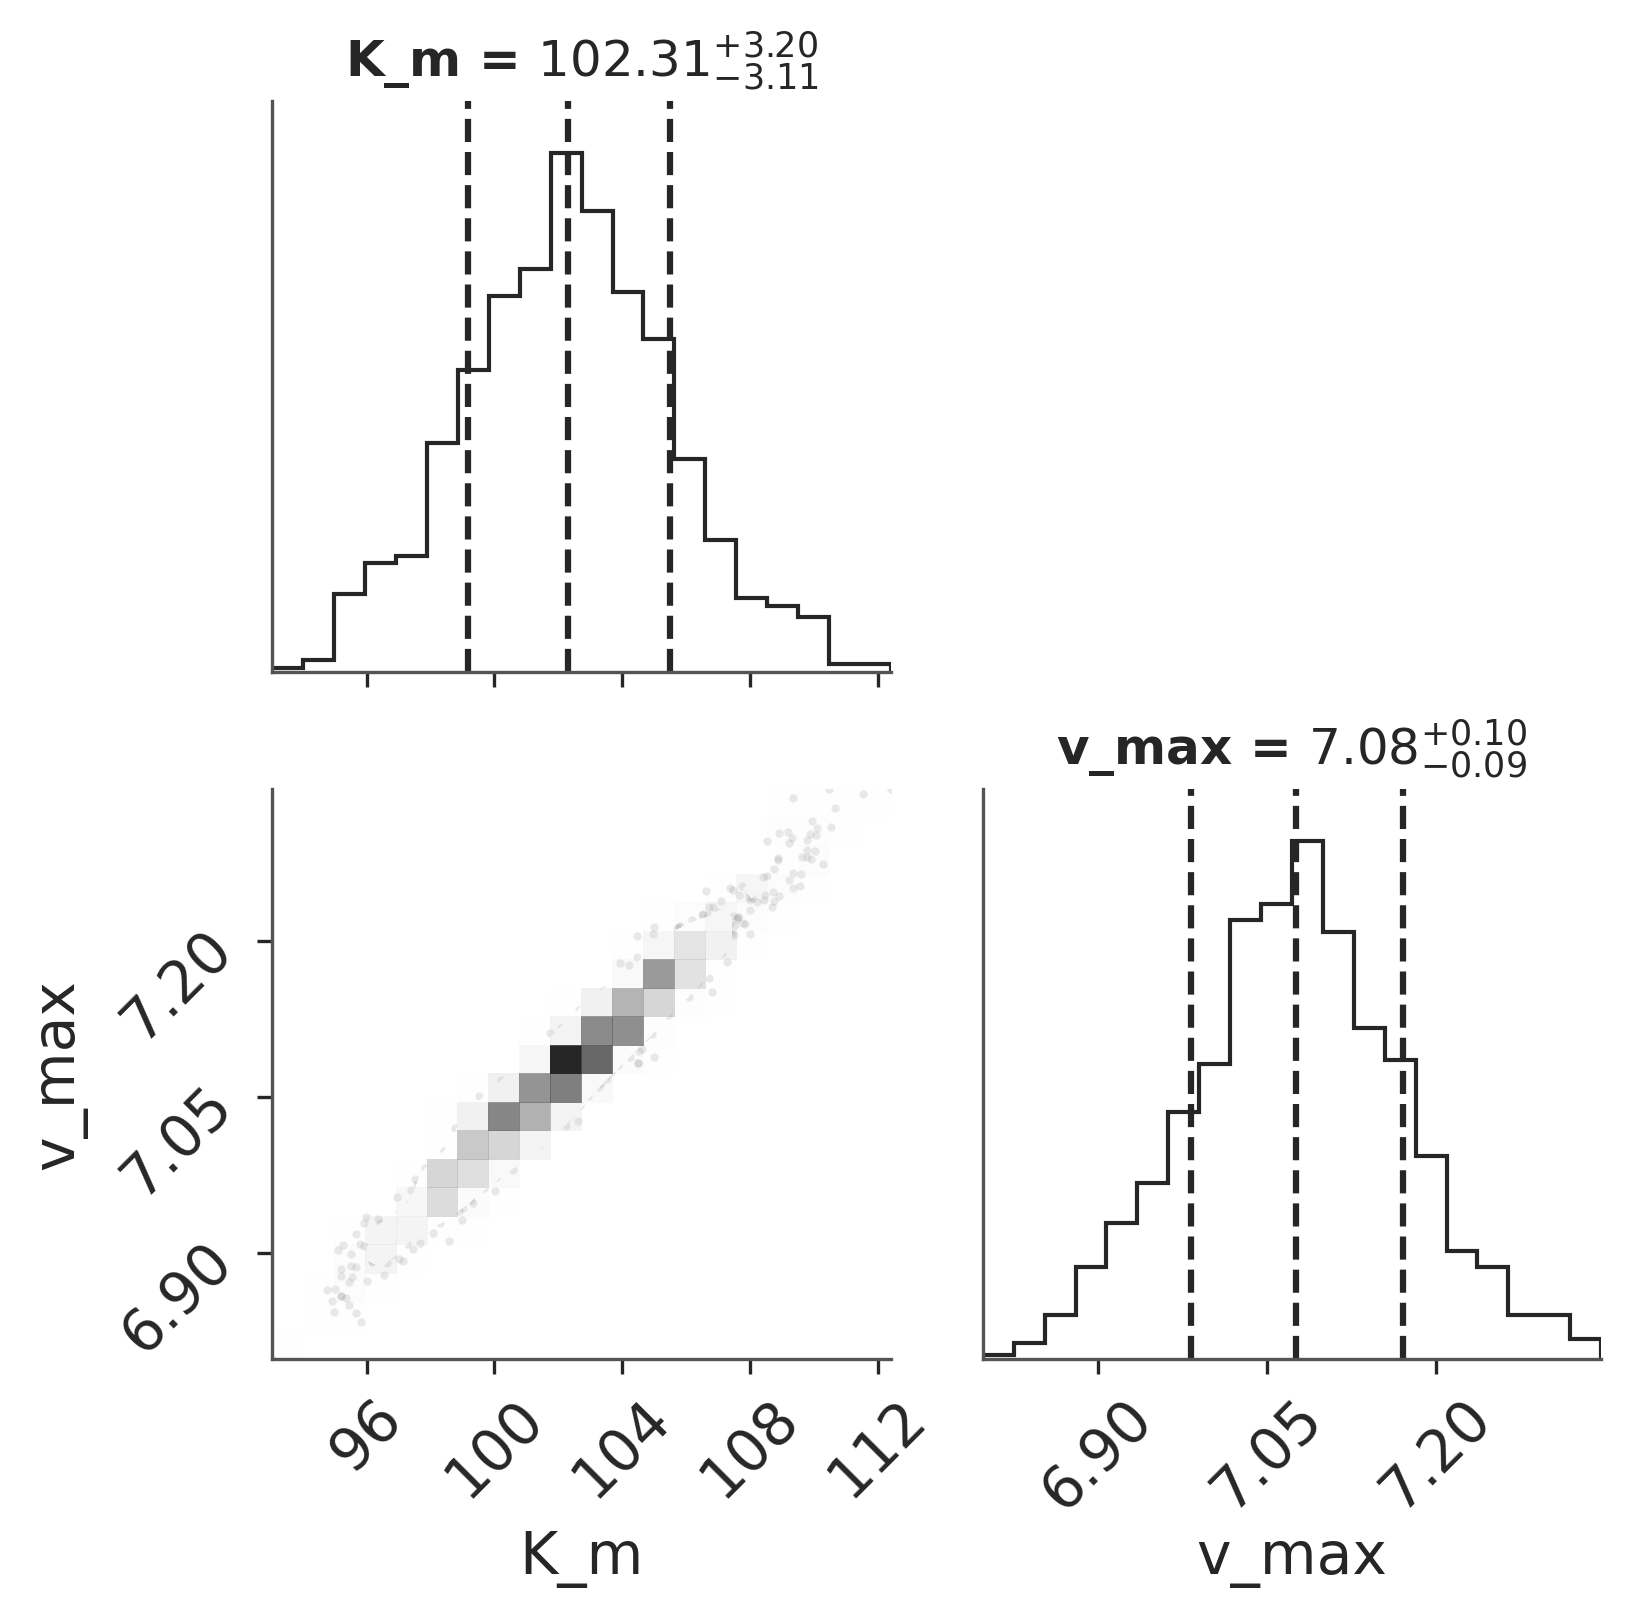

In [9]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


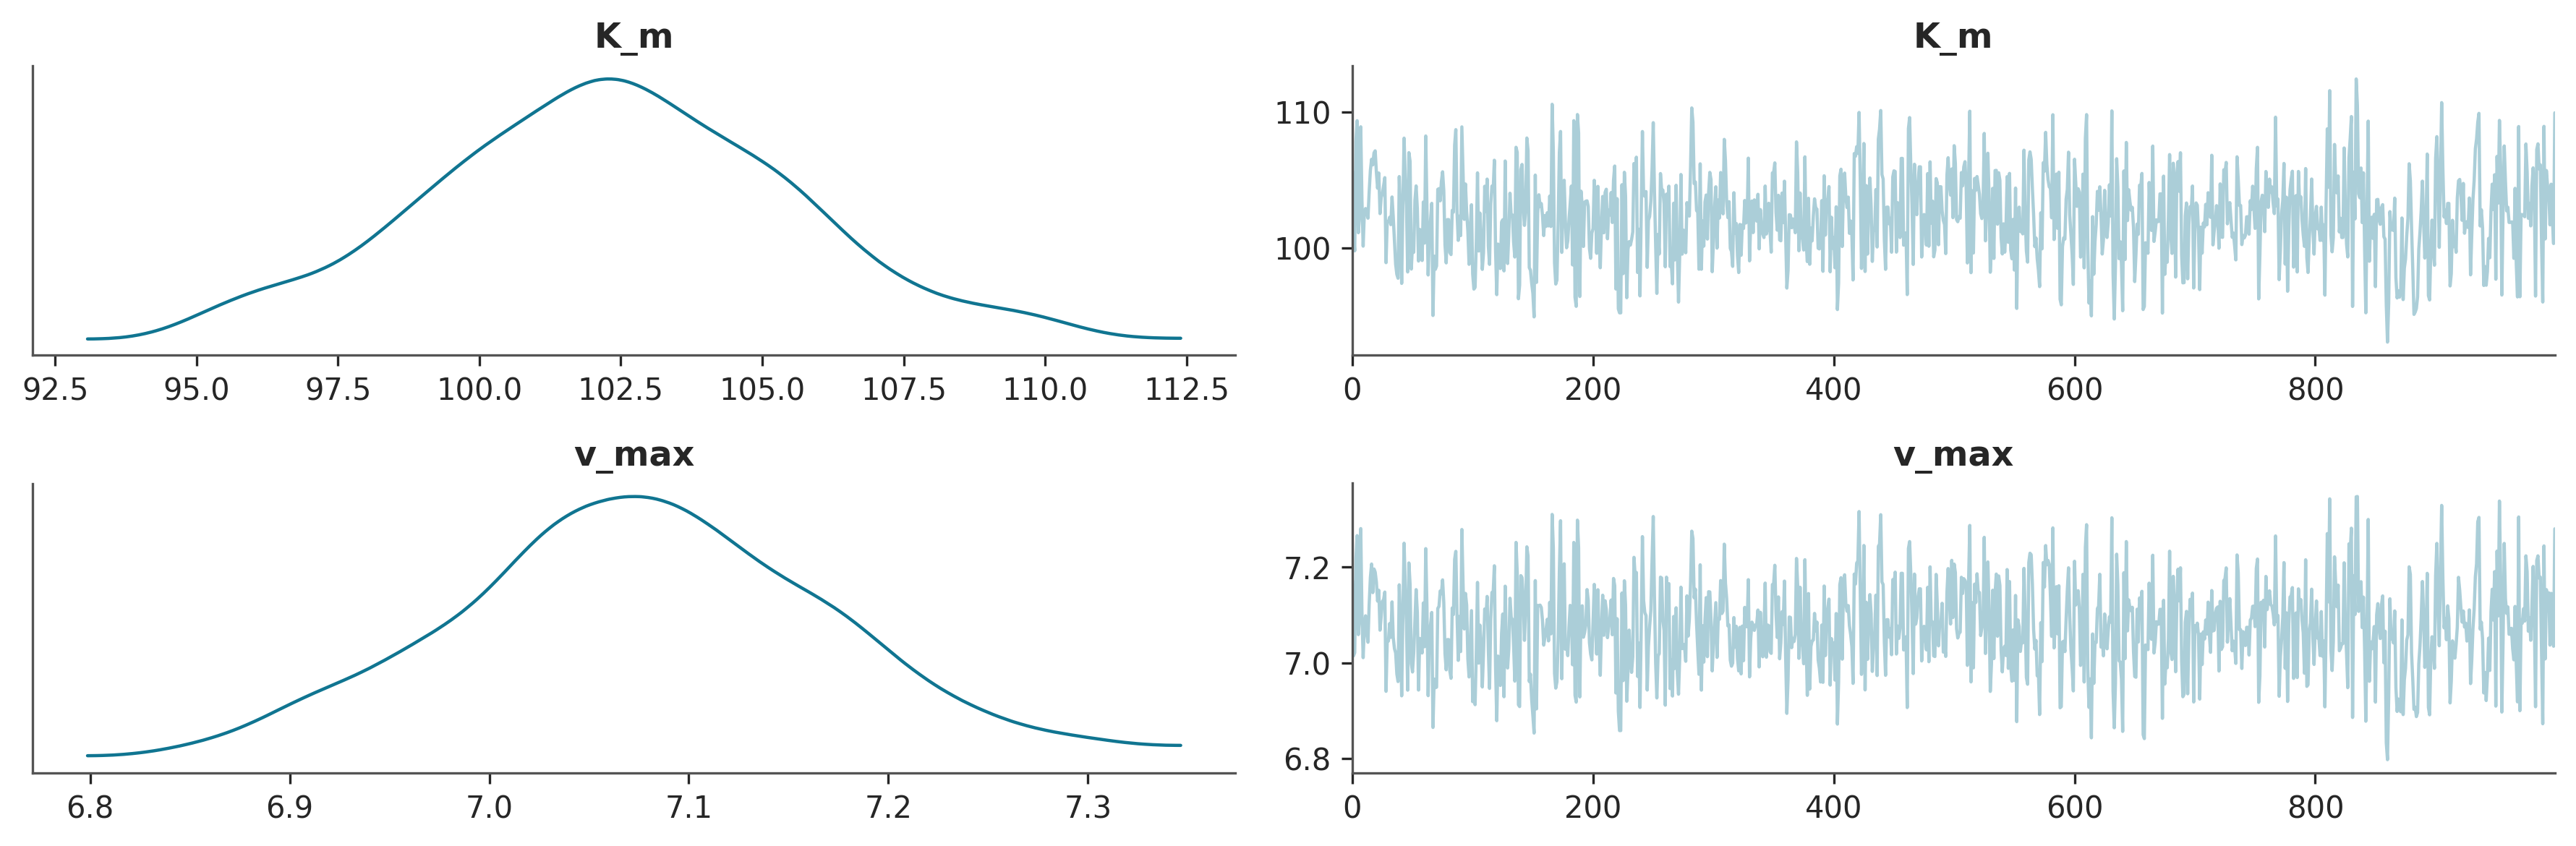

In [10]:
# Plot the trace of the MCMC (Posterior dist and chain trace)
f = cmc.plot_trace(mcmc, model)

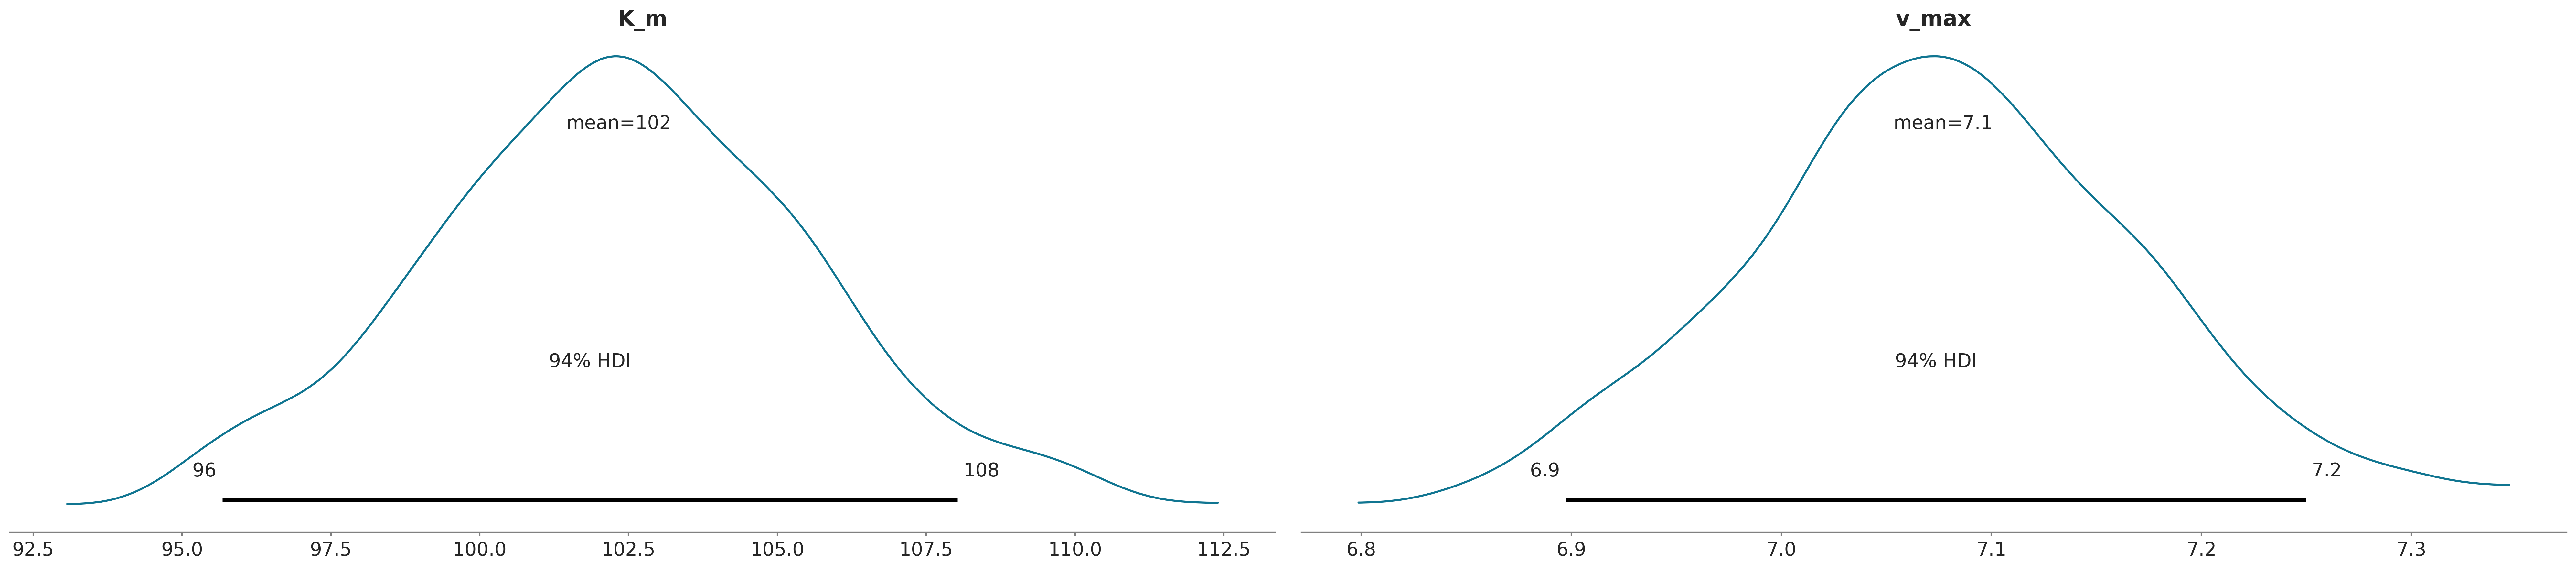

In [11]:
# Variant of plotting the posterior with HDPI
f = cmc.plot_posterior(mcmc, model)

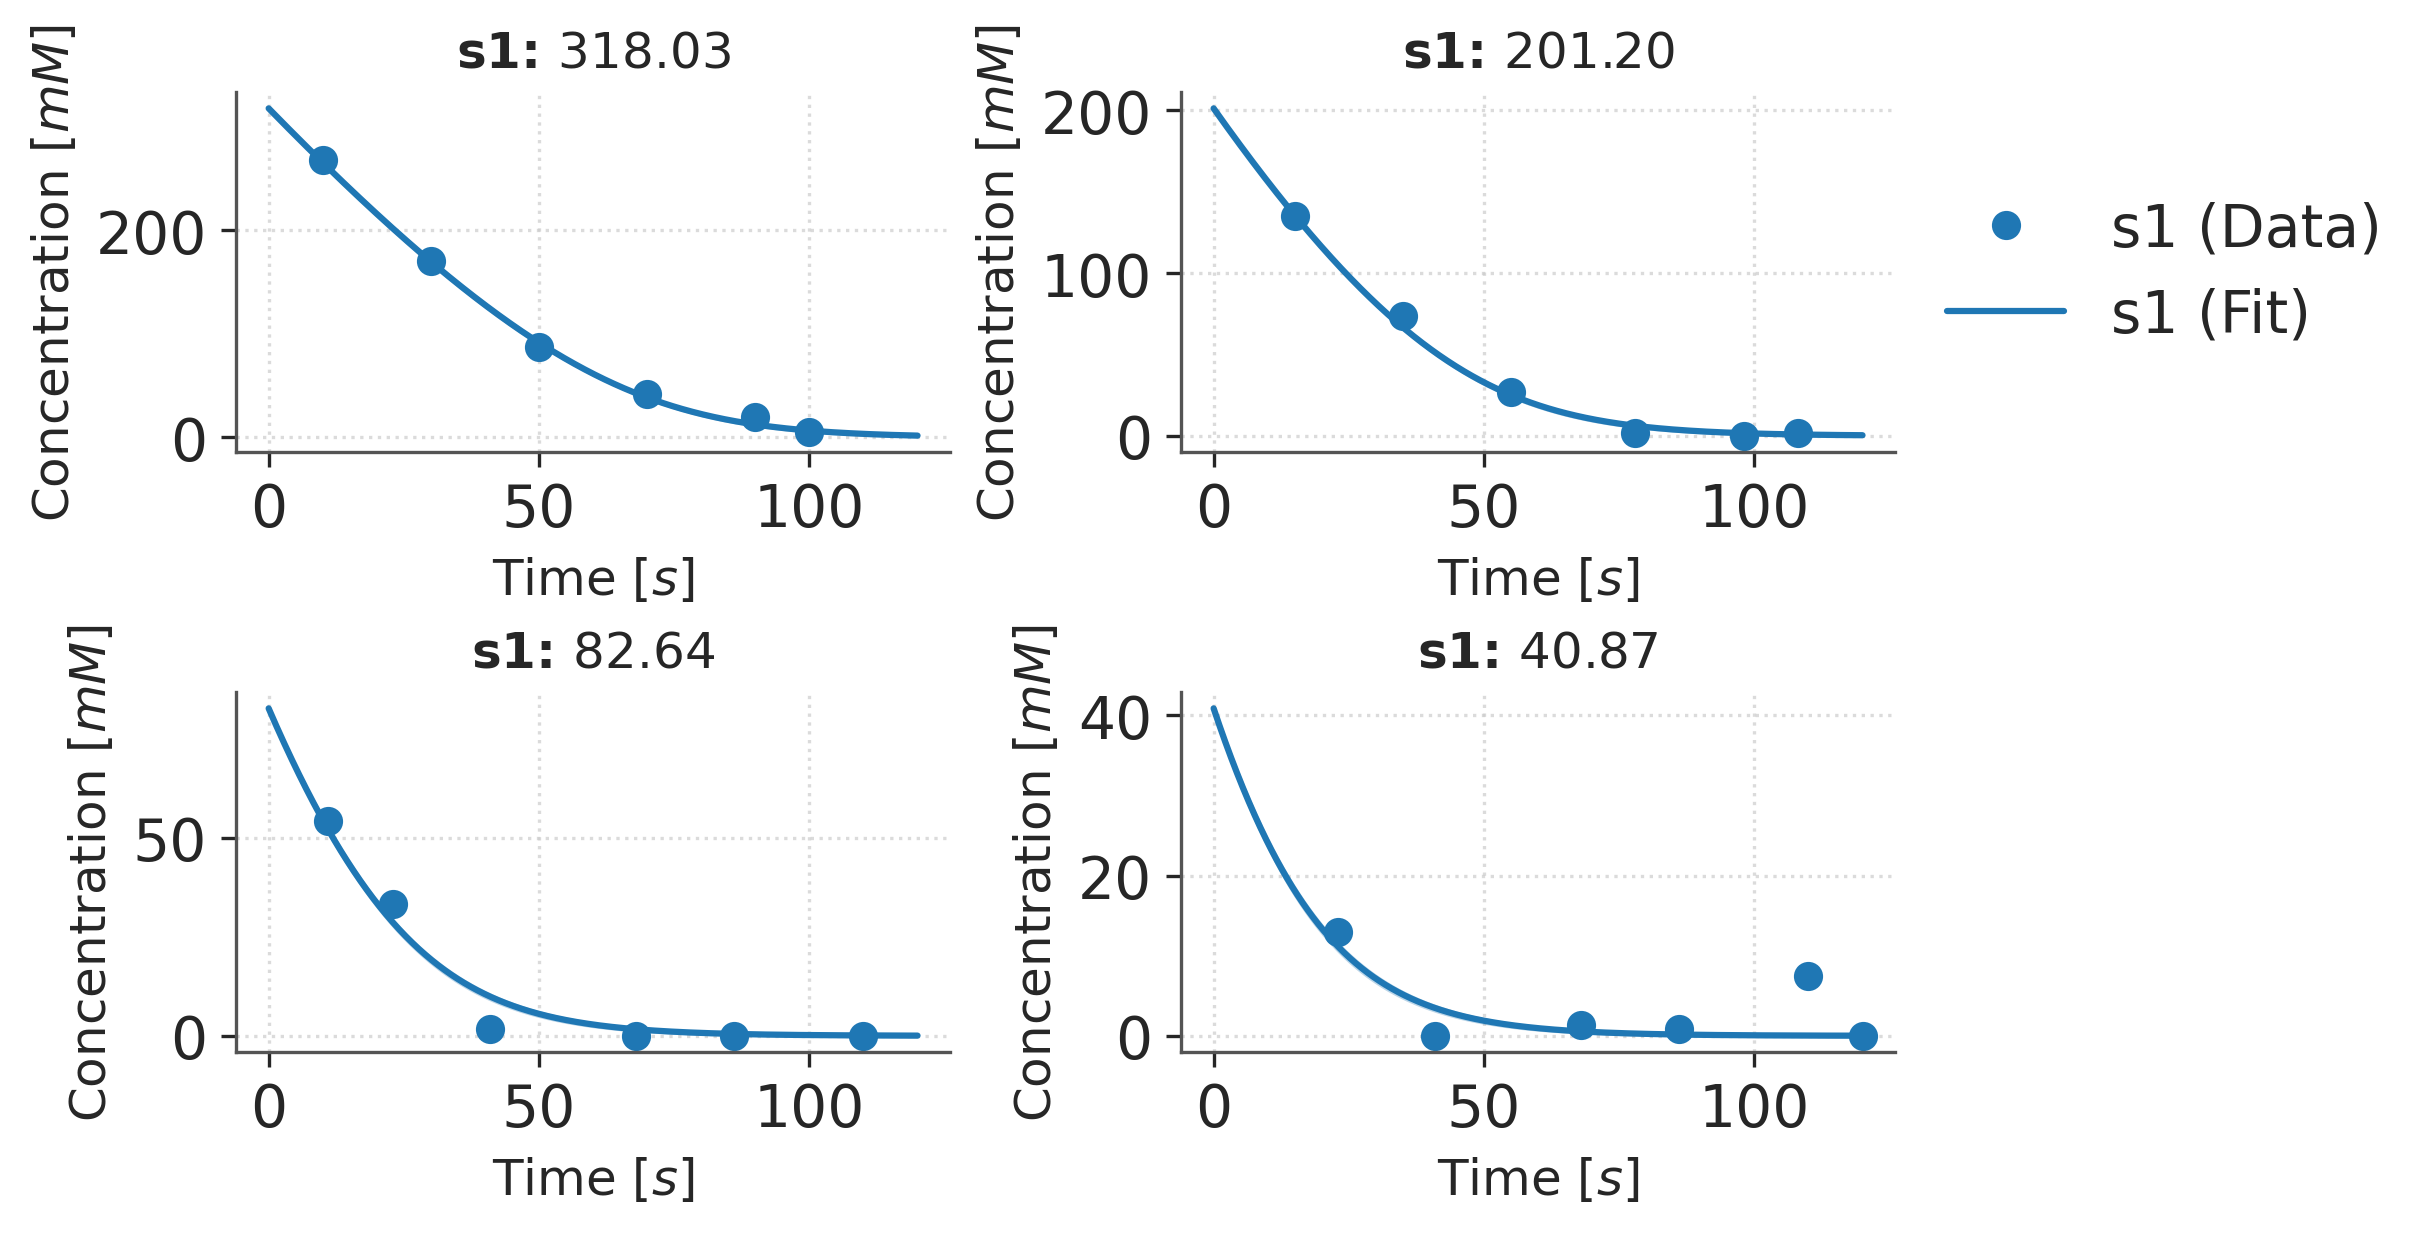

In [12]:
# Visualize fit of MCMC to data
#
# When an mcmc object is passed to visualize, the fit is plotted
# including the 90% highest posterior density interval (HPDI) of
# the parameters and thus the uncertainty of the fit.
#
# In order to see the effects, change the line in the beginning
# to the following:
#       
#      data = np.random.normal(data, 15.0).clip(min=0)
#
# This will add some noise to the data and the fit will be less
# certain and the HPDI will be wider.


f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
    mcmc=mcmc
)